# Generative Adversarial Network Example

Build a generative adversarial network (GAN) to generate digit images from a noise distribution with TensorFlow.

*Note: Currently running error in Colab: https://stackoverflow.com/questions/37337728/tensorflow-internalerror-blas-sgemm-launch-failed

- Adapeted from Author: Aymeric Damien
- https://github.com/aymericdamien/TensorFlow-Examples/
- Orignal Colab: https://colab.research.google.com/drive/1iesmx8m1_MxRo_JZfxl9LzJB9zQXr_we

## GAN Overview

<img src="http://www.timzhangyuxuan.com/static/images/project_DCGAN/structure.png" alt="nn" style="width: 800px;"/>

## MNIST Dataset Overview

This example is using MNIST handwritten digits. The dataset contains 60,000 examples for training and 10,000 examples for testing. The digits have been size-normalized and centered in a fixed-size image (28x28 pixels) with values from 0 to 1. For simplicity, each image has been flattened and converted to a 1-D numpy array of 784 features (28*28).

![MNIST Dataset](http://neuralnetworksanddeeplearning.com/images/mnist_100_digits.png)

More info: http://yann.lecun.com/exdb/mnist/

In [18]:
from __future__ import division, print_function, absolute_import

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

!pip install -U tensorboardcolab
from tensorboardcolab import *
import shutil

#clean out the directory
shutil.rmtree('./Graph', ignore_errors=True)
os.mkdir('./Graph')

tf.reset_default_graph()

#will start the tunneling and will print out a link:
tbc=TensorBoardColab()

Requirement already up-to-date: tensorboardcolab in /usr/local/lib/python2.7/dist-packages (0.0.12)
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Wait for 8 seconds...
TensorBoard link:
http://336b8fd4.ngrok.io


In [19]:
# Import MNIST data
from tensorflow.examples.tutorials.mnist import input_data
#mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)
mnist = input_data.read_data_sets('data/fashion', one_hot=True, source_url='http://fashion-mnist.s3-website.eu-central-1.amazonaws.com/')

Extracting data/fashion/train-images-idx3-ubyte.gz
Extracting data/fashion/train-labels-idx1-ubyte.gz
Extracting data/fashion/t10k-images-idx3-ubyte.gz
Extracting data/fashion/t10k-labels-idx1-ubyte.gz


In [0]:
# Training Params
num_steps = 10000
batch_size = 128
learning_rate = 0.0004

# Network Params
image_dim = 784 # 28*28 pixels
gen_hidden_dim = 256
disc_hidden_dim = 256
noise_dim = 100 # Noise data points

# A custom initialization (see https://stats.stackexchange.com/questions/319323/whats-the-difference-between-variance-scaling-initializer-and-xavier-initialize)
def glorot_init(shape):
    return tf.random_normal(shape=shape, stddev=1. / tf.sqrt(shape[0] / 2.))

In [0]:
# Store layers weight & bias
weights = {
    'gen_hidden1': tf.Variable(glorot_init([noise_dim, gen_hidden_dim]), name='weights_ghid'),
    'gen_out': tf.Variable(glorot_init([gen_hidden_dim, image_dim]), name='weights_gout'),
    'disc_hidden1': tf.Variable(glorot_init([image_dim, disc_hidden_dim]), name='weights_dhid'),
    'disc_out': tf.Variable(glorot_init([disc_hidden_dim, 1]), name='weights_dout'),
}
biases = {
    'gen_hidden1': tf.Variable(tf.zeros([gen_hidden_dim]), name='bias_ghid'),
    'gen_out': tf.Variable(tf.zeros([image_dim]), name='bias_gout'),
    'disc_hidden1': tf.Variable(tf.zeros([disc_hidden_dim]), name='bias_dhid'),
    'disc_out': tf.Variable(tf.zeros([1]), name='bias_dout'),
}

### GAN Loss (Losses)

An important difference between the GAN networks and the other networks we've seen so far is that GAN networks are essentially 2 networks contained in 1 (i.e. a GAN encapsulates the generator's model and the discriminator's model into one network). Thus, we have loss and optimization separate for both the generator and the discriminator. In fact, in this particular example we actually have 3 inputs and 2 losses: 1 input for the generator loss output, and 1 input for the discriminator for fake/generator samples plus 1 input for the discriminator for real/true samples. The 2 discriminator inputs are then summed for the discriminator loss output.

The loss functions are both logistic (negative loss likelihood), which you can read more on [here](https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/)

Note the generator performs a bit like a decoder - instead of reducing dimensions to a target (or class of labels), it expands from a smaller dimension space to the image dimension

In [1]:
#This function performns a leaky relu activation, which is needed for the discriminator network.
def lrelu(x, leak=0.2, name="lrelu"):
     with tf.variable_scope(name):
         f1 = 0.5 * (1 + leak)
         f2 = 0.5 * (1 - leak)
         return f1 * x + f2 * abs(x)

# Generator
def generator(x):
    hidden_layer = tf.matmul(x, weights['gen_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['gen_hidden1'])
    hidden_layer = lrelu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['gen_out'])
    out_layer = tf.add(out_layer, biases['gen_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer


# Discriminator
def discriminator(x):
    hidden_layer = tf.matmul(x, weights['disc_hidden1'])
    hidden_layer = tf.add(hidden_layer, biases['disc_hidden1'])
    hidden_layer = lrelu(hidden_layer)
    out_layer = tf.matmul(hidden_layer, weights['disc_out'])
    out_layer = tf.add(out_layer, biases['disc_out'])
    out_layer = tf.nn.sigmoid(out_layer)
    return out_layer

# Build Networks
# Network Inputs
gen_input = tf.placeholder(tf.float32, shape=[None, noise_dim], name='input_noise')
disc_input = tf.placeholder(tf.float32, shape=[None, image_dim], name='disc_input')

# Build Generator Network
gen_sample = generator(gen_input)
print(gen_sample.get_shape())

# Build 2 Discriminator Networks (one from noise input, one from generated samples)
disc_real = discriminator(disc_input)
disc_fake = discriminator(gen_sample)
print(disc_real.get_shape(), disc_fake.get_shape())

# Build Loss (note that below reduces to a scalar from (1 x 128) vector, 128 being batch_size)
# Note we are also taking the inverse of the disc_fake loss for the gen_loss
# If we wish to perform loss by class, then we must rework some graph elements
gen_loss = -tf.reduce_mean(tf.log(disc_fake))
tf.summary.scalar("gen_loss", gen_loss)

disc_loss = -tf.reduce_mean(tf.log(disc_real) + tf.log(1. - disc_fake))
tf.summary.scalar("disc_loss", disc_loss)

# Build Optimizers
optimizer_gen = tf.train.AdamOptimizer(learning_rate=learning_rate)
optimizer_disc = tf.train.AdamOptimizer(learning_rate=learning_rate)

# Training Variables for each optimizer
# By default in TensorFlow, all variables are updated by each optimizer, so we
# need to precise for each one of them the specific variables to update.
# Generator Network Variables
gen_vars = [weights['gen_hidden1'], weights['gen_out'],
            biases['gen_hidden1'], biases['gen_out']]
tf.summary.histogram("weights_gen_hid", gen_vars[0])
tf.summary.histogram("weights_gen_out", gen_vars[1])
tf.summary.histogram("biases_gen_hid", gen_vars[2])
tf.summary.histogram("biases_gen_out", gen_vars[3])

# Discriminator Network Variables
disc_vars = [weights['disc_hidden1'], weights['disc_out'],
            biases['disc_hidden1'], biases['disc_out']]
tf.summary.histogram("weights_disc_hid", disc_vars[0])
tf.summary.histogram("weights_disc_out", disc_vars[1])
tf.summary.histogram("biases_disc_hid", disc_vars[2])
tf.summary.histogram("biases_disc_out", disc_vars[3])

# Create training operations
train_gen = optimizer_gen.minimize(gen_loss, var_list=gen_vars)
train_disc = optimizer_disc.minimize(disc_loss, var_list=disc_vars)

# Initialize the variables (i.e. assign their default value)
init = tf.global_variables_initializer()

NameError: name 'tf' is not defined

In [23]:
gen_vars[0]

<tf.Variable 'weights_ghid:0' shape=(100, 256) dtype=float32_ref>

Step 1: Generator Loss: 1.034698, Discriminator Loss: 1.235910


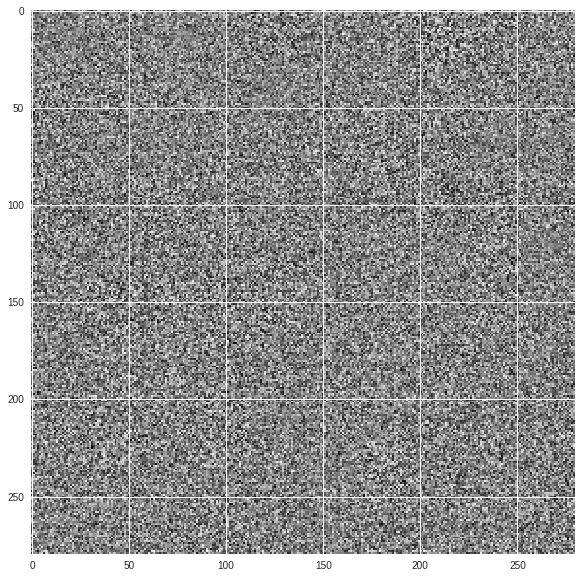

Step 2000: Generator Loss: 5.850739, Discriminator Loss: 0.054768


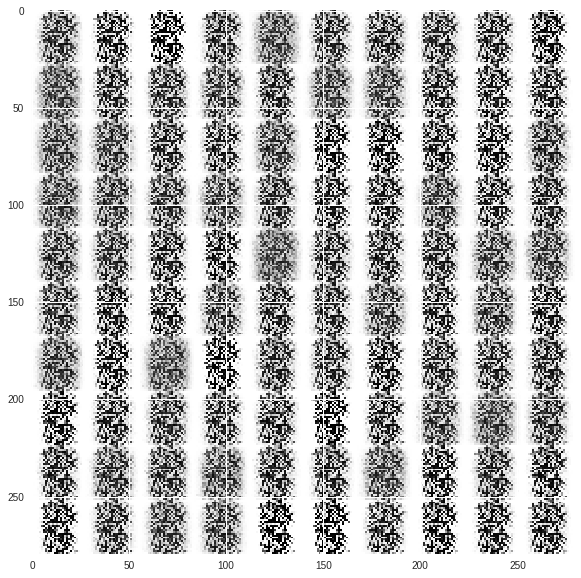

Step 4000: Generator Loss: 3.266659, Discriminator Loss: 0.135850


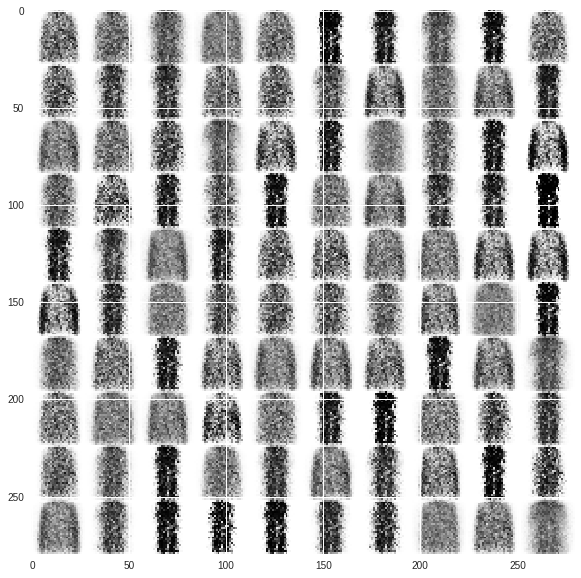

Step 6000: Generator Loss: 2.505430, Discriminator Loss: 0.197099


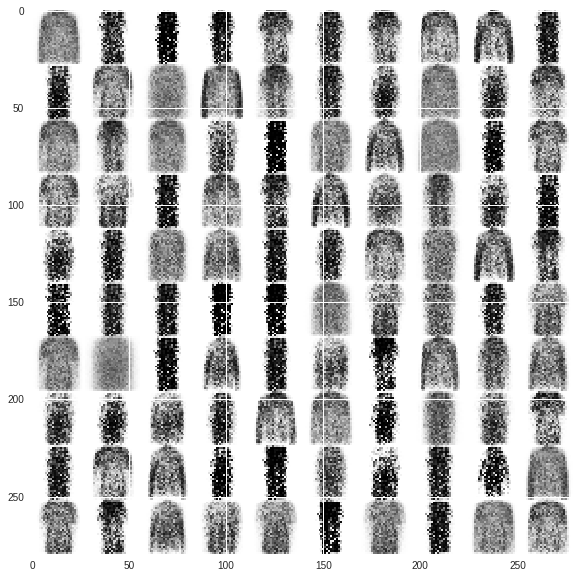

Step 8000: Generator Loss: 3.077174, Discriminator Loss: 0.258129


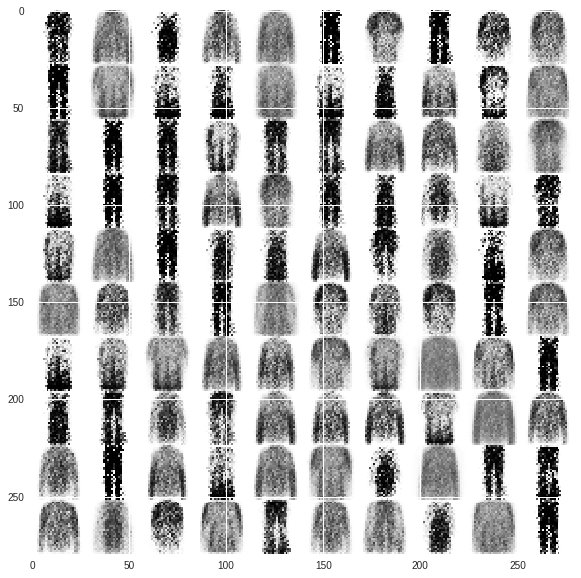

Step 10000: Generator Loss: 3.104955, Discriminator Loss: 0.265097


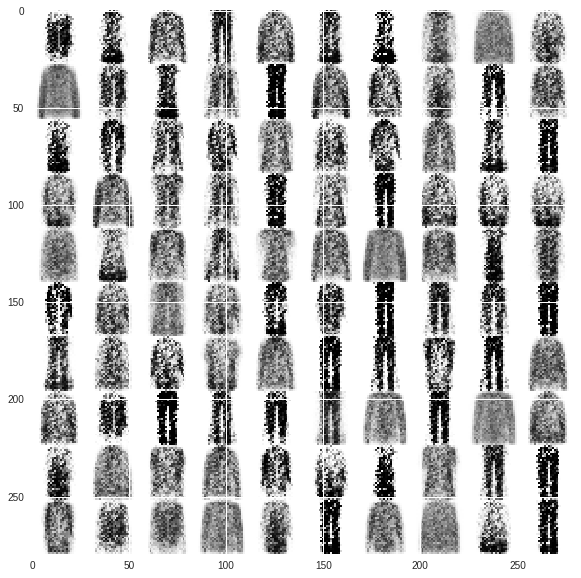

In [25]:
# Start Training
# Start a new TF session
sess = tf.Session()
## merge all our Tensorboard summaries and create file directory
summaryMerged = tf.summary.merge_all()
#filename="./summary_log/run"+datetime.datetime.now().strftime("%Y-%m-%d--%H-%M-%S")
#writer = tf.summary.FileWriter(filename, session.graph)

#if on colab
writer = tbc.get_writer();
writer.add_graph(sess.graph)
# Run the initializer
sess.run(init)

# Training
for i in range(1, num_steps+1):
    # Prepare Data
    # Get the next batch of MNIST data (only images are needed, not labels)
    batch_x, _ = mnist.train.next_batch(batch_size)
    # Generate noise to feed to the generator
    z = np.random.uniform(-1., 1., size=[batch_size, noise_dim])

    # Train
    feed_dict = {disc_input: batch_x, gen_input: z}
    _, _, gl, dl, sumOut = sess.run([train_gen, train_disc, gen_loss, disc_loss, summaryMerged],
                            feed_dict=feed_dict)
    if i % 2000 == 0 or i == 1:
        # write out tensorboard             
        writer.add_summary(sumOut, i)
        #for colab

        writer.flush()
        # Calculate the accuracy on the training-set.
        
        print('Step %i: Generator Loss: %f, Discriminator Loss: %f' % (i, gl, dl))
        # Testing
        # Generate images from noise, using the generator network.
        n = 10
        canvas = np.empty((28 * n, 28 * n))
        for i in range(n):
            # Noise input.
            z = np.random.uniform(-1., 1., size=[n, noise_dim])
            # Generate image from noise.
            g = sess.run(gen_sample, feed_dict={gen_input: z})
            # Reverse colours for better display
            g = -1 * (g - 1)
            for j in range(n):
                # Draw the generated digits
                canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = g[j].reshape([28, 28])

        plt.figure(figsize=(n, n))
        plt.imshow(canvas, origin="upper", cmap="gray")
        plt.show()

In [7]:
# get all operations in graph
for op in tf.get_default_graph().get_operations(): 
    print(op.name)

Sqrt/x
Sqrt
truediv/x
truediv
random_normal/shape
random_normal/mean
random_normal/RandomStandardNormal
random_normal/mul
random_normal
weights_ghid
weights_ghid/Assign
weights_ghid/read
Sqrt_1/x
Sqrt_1
truediv_1/x
truediv_1
random_normal_1/shape
random_normal_1/mean
random_normal_1/RandomStandardNormal
random_normal_1/mul
random_normal_1
weights_gout
weights_gout/Assign
weights_gout/read
Sqrt_2/x
Sqrt_2
truediv_2/x
truediv_2
random_normal_2/shape
random_normal_2/mean
random_normal_2/RandomStandardNormal
random_normal_2/mul
random_normal_2
weights_dhid
weights_dhid/Assign
weights_dhid/read
Sqrt_3/x
Sqrt_3
truediv_3/x
truediv_3
random_normal_3/shape
random_normal_3/mean
random_normal_3/RandomStandardNormal
random_normal_3/mul
random_normal_3
weights_dout
weights_dout/Assign
weights_dout/read
zeros
bias_ghid
bias_ghid/Assign
bias_ghid/read
zeros_1
bias_gout
bias_gout/Assign
bias_gout/read
zeros_2
bias_dhid
bias_dhid/Assign
bias_dhid/read
zeros_3
bias_dout
bias_dout/Assign
bias_dout/read


In [8]:
# get operations of only a certain name/variable 
print([op for op in tf.get_default_graph().get_operations() if 'out' in op.name and op.type == 'VariableV2'])

[<tf.Operation 'weights_gout' type=VariableV2>, <tf.Operation 'weights_dout' type=VariableV2>, <tf.Operation 'bias_gout' type=VariableV2>, <tf.Operation 'bias_dout' type=VariableV2>, <tf.Operation 'weights_gout/Adam' type=VariableV2>, <tf.Operation 'weights_gout/Adam_1' type=VariableV2>, <tf.Operation 'bias_gout/Adam' type=VariableV2>, <tf.Operation 'bias_gout/Adam_1' type=VariableV2>, <tf.Operation 'weights_dout/Adam' type=VariableV2>, <tf.Operation 'weights_dout/Adam_1' type=VariableV2>, <tf.Operation 'bias_dout/Adam' type=VariableV2>, <tf.Operation 'bias_dout/Adam_1' type=VariableV2>]


In [9]:
# get shape of output of certain ops
op = tf.get_default_graph().get_operations()
print([m.values() for m in op if 'weights' in m.name and m.type == 'VariableV2'])

[(<tf.Tensor 'weights_ghid:0' shape=(100, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_gout:0' shape=(256, 784) dtype=float32_ref>,), (<tf.Tensor 'weights_dhid:0' shape=(784, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_dout:0' shape=(256, 1) dtype=float32_ref>,), (<tf.Tensor 'weights_ghid/Adam:0' shape=(100, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_ghid/Adam_1:0' shape=(100, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_gout/Adam:0' shape=(256, 784) dtype=float32_ref>,), (<tf.Tensor 'weights_gout/Adam_1:0' shape=(256, 784) dtype=float32_ref>,), (<tf.Tensor 'weights_dhid/Adam:0' shape=(784, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_dhid/Adam_1:0' shape=(784, 256) dtype=float32_ref>,), (<tf.Tensor 'weights_dout/Adam:0' shape=(256, 1) dtype=float32_ref>,), (<tf.Tensor 'weights_dout/Adam_1:0' shape=(256, 1) dtype=float32_ref>,)]


In [0]:
def plot_weights(weights, img_shape=image_dim):
    # Get the values for the weights from the TensorFlow variable.
    # weights_gout is 256 x 784
    n = 10
    canvas = np.empty((28 * n, 28 * n))
    for i in range(n):
        # Noise input with very random spread
        z = 1/(i+1) * np.random.randn(n, noise_dim)+0
        # Generate image from noise.
        w = sess.run(weights, feed_dict={gen_input: z})
        # Reverse colours for better display
        #w = -1 * (w)
        for j in range(n):
            # Draw a sampling from the weights' space (100 x 784)
            canvas[i * 28:(i + 1) * 28, j * 28:(j + 1) * 28] = w[np.random.randint(0,256)].reshape([28, 28])

    plt.figure(figsize=(n, n))
    plt.imshow(canvas, origin="upper", cmap="gray")
    plt.show()

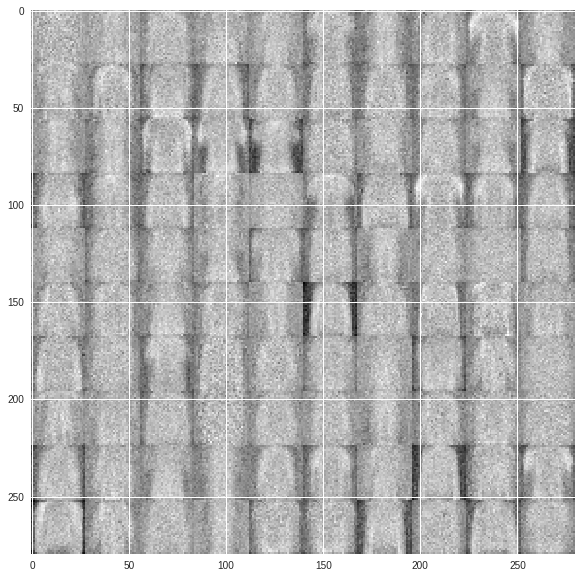

In [11]:
weight = tf.get_default_graph().get_tensor_by_name('weights_gout:0')
plot_weights(weight)

In [12]:
TO-DO: Convert to Quickdraw and Fashion-MNIST datasets. Convert to 3-channel color data (CIFAR-10).

SyntaxError: ignored